# Projet 3A

texte

## Segmentation des fragments rocheux

Texte

In [1]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt

Load the image using cv2, by default in bgr format

In [13]:
IMAGE_PATH = './RRP_lorraine/F57084r.jpg'

IMAGE_NAME = os.path.splitext(os.path.basename(IMAGE_PATH))[0]

image_bgr = cv2.imread(IMAGE_PATH)

In [3]:
DIR_NAME = 'saved/' + IMAGE_PATH.strip('.jpg').split('/')[-1]
current_dir = os.getcwd()
SAVE_DIR_NAME = os.path.join(current_dir, DIR_NAME)
if not os.path.exists(SAVE_DIR_NAME):
   os.makedirs(SAVE_DIR_NAME)

os.chdir(SAVE_DIR_NAME)

### 2.1 Pre-Segmentation

In [4]:
# Conversion vers HSV
image_hsv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)
channel_names = ['Hue', 'Saturation', 'Value']

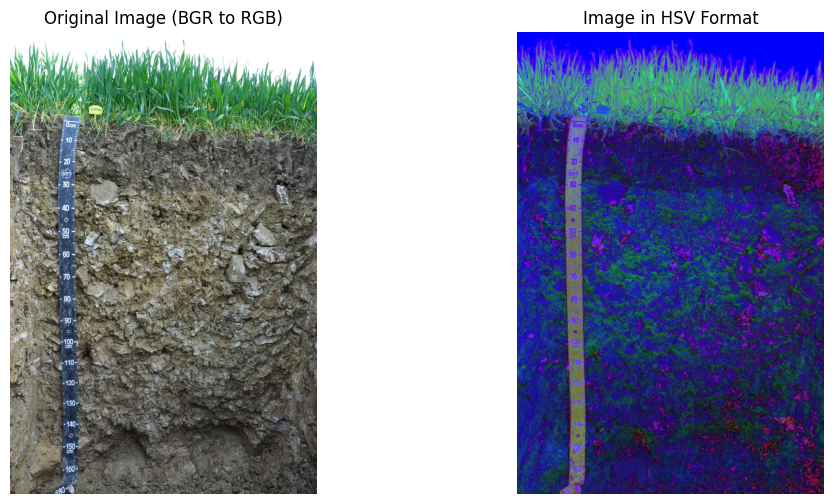

In [5]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))
plt.title('Original Image (BGR to RGB)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_hsv, cmap = 'hsv')  # HSV visualization
plt.title('Image in HSV Format')
plt.axis('off')

plt.show()

Separate the Hue, Saturation and Value channels

In [6]:
hue, saturation, value = cv2.split(image_hsv)

split_hsv = [hue, saturation, value]

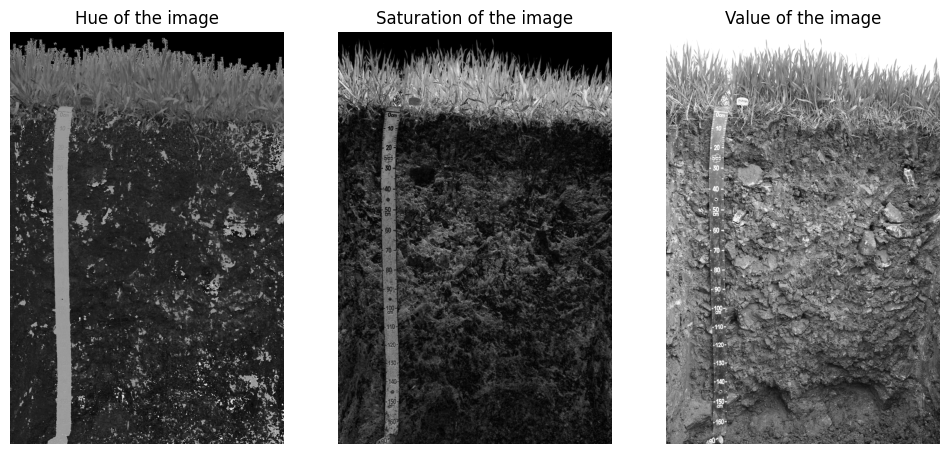

In [7]:
plt.figure(figsize=(12, 6))

for i in range(3):
    plt.subplot(1, 3, 1 + i)
    plt.imshow(split_hsv[i], cmap = 'gray')
    plt.title(channel_names[i] + ' of the image')
    plt.axis('off')

plt.show()

In [8]:
for i in range(len(channel_names)):
    filename = channel_names[i] + '.jpg' #SAVE_DIR_NAME + '/' + IMAGE_NAME + '/' + channel_names[i] + '.jpg'
    cv2.imwrite(filename, split_hsv[i])

Shadow removal to help the value channel yield better results

In [9]:
# Morphological operations
shadow_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (21, 21))
background = cv2.morphologyEx(value, cv2.MORPH_CLOSE, shadow_kernel)

# Normalize image to remove shadows
shadow_free = cv2.divide(value, background, scale=255)

split_hsv[2] = shadow_free

Shadow results

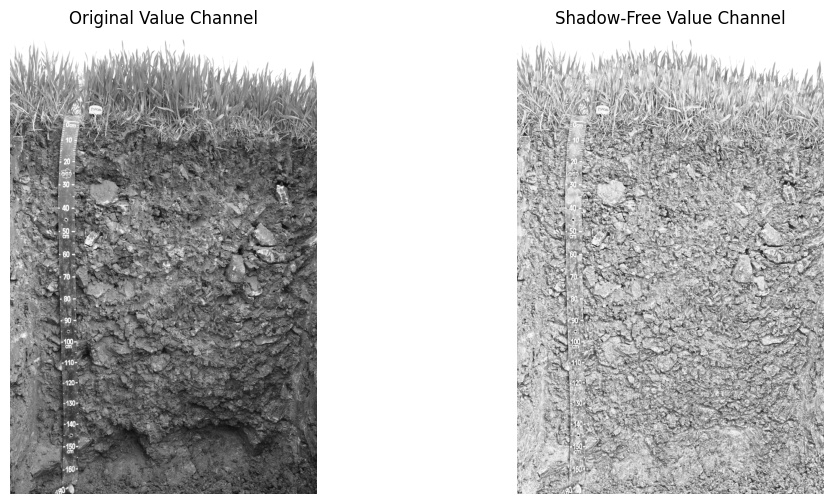

In [10]:
plt.figure(figsize = (12, 6))

plt.subplot(1, 2, 1)
plt.imshow(value, cmap = 'gray')
plt.title('Original Value Channel')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(shadow_free, cmap = 'gray')
plt.title('Shadow-Free Value Channel')
plt.axis('off')

plt.show()

In [18]:
filename = 'shadow_free_value.jpg'
cv2.imwrite(filename, split_hsv[i])

True

Apply a maximum filter to enhance the contrast between small particle-size objects and the soil matrix in the saturation channel.

In [19]:
max_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2 * 2 + 1, 2 * 2 + 1))
max_filtered = cv2.dilate(saturation, max_kernel)
max_filtered = cv2.normalize(max_filtered, None, 0, 255, cv2.NORM_MINMAX) # optional

split_hsv[1] = max_filtered

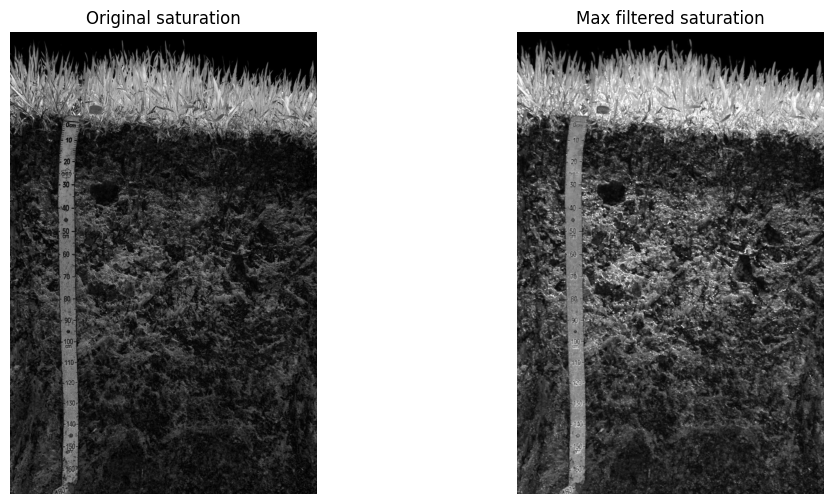

In [20]:
plt.figure(figsize = (12, 6))

plt.subplot(1, 2, 1)
plt.imshow(saturation, cmap = 'gray')
plt.title('Original saturation')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(max_filtered, cmap = 'gray')
plt.title('Max filtered saturation')
plt.axis('off')

plt.show()

In [22]:
filename ='max_filtered_saturation.jpg'
cv2.imwrite(filename, split_hsv[1])


True

The Gaussian filter was used to “fuzzy” the image, to highlight the targets, to restrain detailed information, such as noise in the image, and to improve the accuracy of segmentation for the next step.

In [23]:
# Will have to fiddle around with the kernel size of the Gaussian blur

kernel_sizes : list = [2 * 7 + 1, 2 * 0 + 1, 2 * 10 + 1]

# In the article it seems like the saturation channel is the only one that gets blurred
# Or perhaps each channel are smoothed differently
for i in range(len(split_hsv)):
    split_hsv[i] = cv2.GaussianBlur(split_hsv[i], (kernel_sizes[i], kernel_sizes[i]), 0)

Display the results

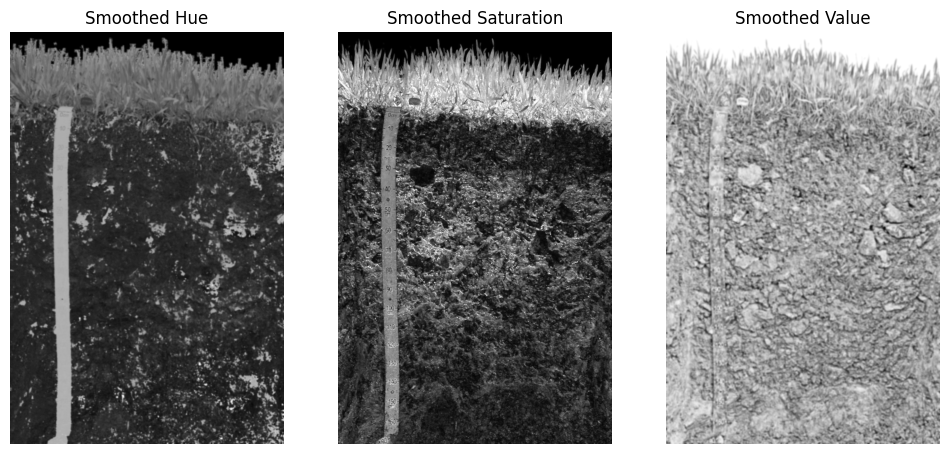

In [24]:
plt.figure(figsize=(12, 6))

for i in range(3):
    plt.subplot(1, 3, 1 + i)
    plt.imshow(split_hsv[i], cmap = 'gray')
    plt.title('Smoothed ' + channel_names[i])
    plt.axis('off')

plt.show()

In [25]:
for i in range(len(channel_names)):
    filename = 'blurred_' + channel_names[i] + '.jpg'
    cv2.imwrite(filename, split_hsv[i])

### 2.2 Segmentation

Thresholding \
According to the article, the Hue channel is better for lower contrast while Value is for medium contrast and Saturation for larger contrast.

In [26]:
# threshold min and max values taken from the article
low_contrast_thresh = [(0, 30), (0, 200), (0, 220)]
med_contrast_thresh = [(30, 120),(0, 50),(0, 150)]
high_contrast_thresh = [(120, 170), (0, 150), (0, 130)]

low_contrast_masks = []
med_contrast_masks = []
high_contrast_masks = []

for i in range(3):
    
    '''
    Looking at the results, it might be better to take the logical opposite 
    for low contrast rfs and for the value channel altogether
    '''
    low_contrast_masks += [cv2.inRange(split_hsv[i], low_contrast_thresh[i][0], low_contrast_thresh[i][1])]
    med_contrast_masks += [cv2.inRange(split_hsv[i], med_contrast_thresh[i][0], med_contrast_thresh[i][1])]
    high_contrast_masks += [cv2.inRange(split_hsv[i], high_contrast_thresh[i][0], high_contrast_thresh[i][1])]

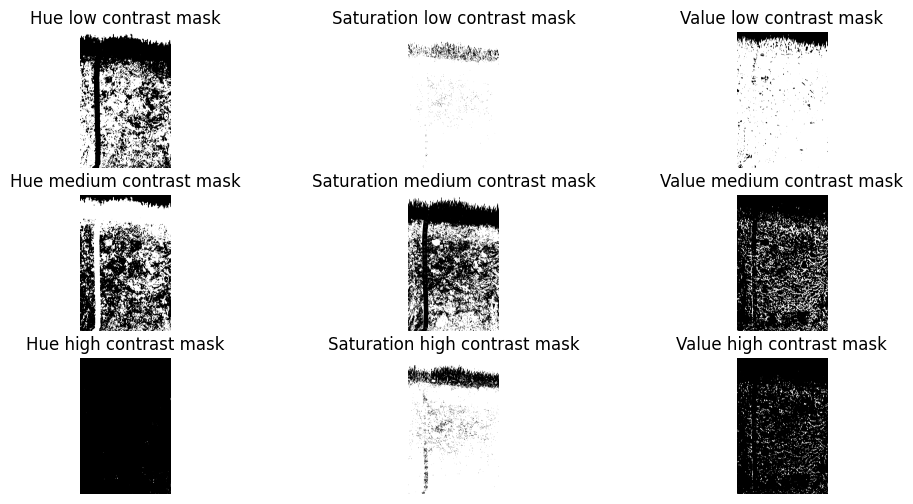

In [27]:
plt.figure(figsize=(12, 6))

for i in range(3) :
    # low contrast
    plt.subplot(3, 3, 1 + i)
    plt.imshow(low_contrast_masks[i], cmap = 'gray')
    plt.title(channel_names[i] + ' low contrast mask')
    plt.axis('off')

    # Medium contrast
    plt.subplot(3, 3, 4 + i)
    plt.imshow(med_contrast_masks[i], cmap = 'gray')
    plt.title(channel_names[i] + ' medium contrast mask')
    plt.axis('off')

    # High contrast
    plt.subplot(3, 3, 7 + i)
    plt.imshow(high_contrast_masks[i], cmap = 'gray')
    plt.title(channel_names[i] + ' high contrast mask')
    plt.axis('off')

plt.show()

In [28]:
for i in range(len(channel_names)):
    # low contrast
    filename = 'low_contrast_mask_' + channel_names[i] + '.jpg'
    cv2.imwrite(filename, low_contrast_masks[i])

    # medium contrast
    filename = 'med_contrast_mask_' + channel_names[i] + '.jpg'
    cv2.imwrite(filename, med_contrast_masks[i])
    
    # high contrast
    filename = 'high_contrast_mask_' + channel_names[i] + '.jpg'
    cv2.imwrite(filename, high_contrast_masks[i])

In [29]:
# Masks kept by rock fragments contrast
# now index 0 is for low contrast, 1 is for medium contrast and 2 is for high contrasting rocks
bin_masks = [cv2.bitwise_not(low_contrast_masks[0]), cv2.bitwise_not(med_contrast_masks[2]), high_contrast_masks[1]]

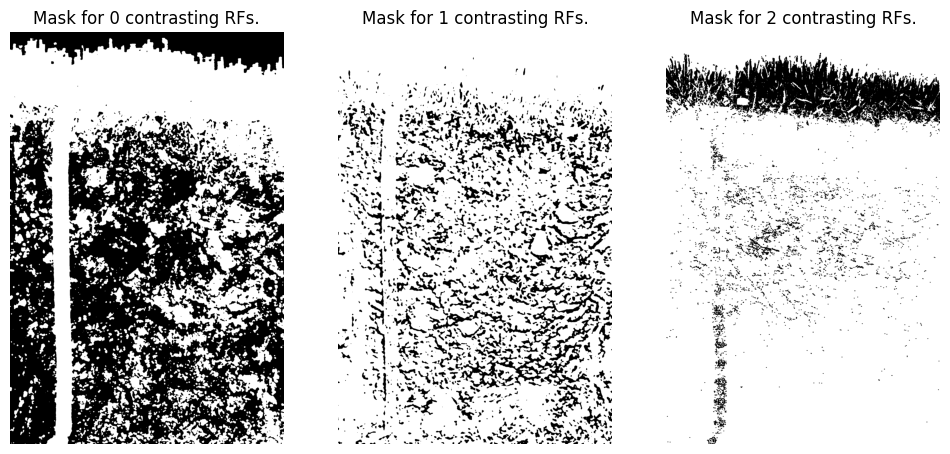

In [30]:
plt.figure(figsize = (12, 6))
for i in range(3):
    plt.subplot(1, 3, 1 + i)
    plt.imshow(bin_masks[i], cmap = 'gray')
    plt.title('Mask for ' + str(i) + ' contrasting RFs.')
    plt.axis('off')

plt.show()